In [2]:
import pandas as pd
import numpy as np
np.random.seed(1)  # fix a seed for reproducible random sampling

# only show counts for these words:
words_of_interest = ['whilst','service','upon', 'the', 'state', 'enough', 'objection']
df = pd.read_csv('federalist-papers.csv', index_col=0)
df[words_of_interest].sample(6)

,whilst,service,upon,the,state,enough,objection
68,0,0,2,142,10,0,1
36,0,0,6,251,25,0,4
74,0,1,3,104,2,0,0
63,1,0,0,290,6,0,0
40,0,0,0,294,6,0,2
54,0,0,2,204,16,0,2


In [3]:
# values associated with the column 'AUTHOR' are one of the following:
# {'HAMILTON', 'MADISON', 'JAY', 'HAMILTON OR MADISON',
#  'HAMILTON AND MADISON'}
# essays with the author 'HAMILTON OR MADISON' are the 12 disputed essays.
disputed_essays = df[df['AUTHOR'] == 'HAMILTON OR MADISON'].index
assert len(disputed_essays) == 12  # there are twelve disputed essays
# numbers widely used to identify the essays
assert set(disputed_essays) == {49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 62, 63}

In [4]:
# gather essays with known authorship: the undisputed essays of
# Madison and Hamilton
df_known = df.loc[df['AUTHOR'].isin(('HAMILTON', 'MADISON'))]
print(df_known['AUTHOR'].value_counts())

HAMILTON    51
MADISON     36
Name: AUTHOR, dtype: int64


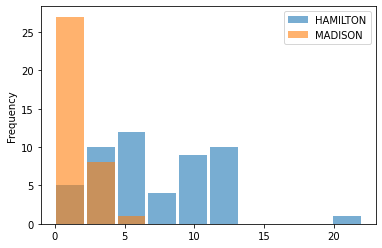

In [5]:
df_known.groupby('AUTHOR')['upon'].plot.hist(
    rwidth=0.9, alpha=0.6, range=(0, 22), legend=True);

In [6]:
df_known.groupby('AUTHOR')['upon'].describe()

,count,mean,std,min,25%,50%,75%,max
AUTHOR,,,,,,,,
HAMILTON,51.0,7.333333,4.008325,2.0,4.0,6.0,10.00,20.0
MADISON,36.0,1.250000,1.574348,0.0,0.0,0.5,2.25,5.0


AUTHOR
HAMILTON    1.0
MADISON     0.5
Name: upon, dtype: float64


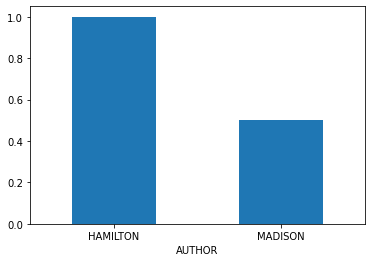

In [8]:
# The expression below applies `mean` to a sequence of binary observations
# to get a proportion. For example,
# np.mean([False, False, True]) == np.mean([0, 0, 1]) == 1/3
proportions = df_known.groupby('AUTHOR')['upon'].apply(
    lambda upon_counts: (upon_counts > 0).mean())
print(proportions)

proportions.plot.bar(rot=0);

In [10]:
author = df['AUTHOR']  # save a copy of the author column
df = df.drop('AUTHOR', axis=1)  # remove the author column
df = df.divide(df.sum(axis=0))  # rate per 1 word
df *= 1000  # transform from rate per 1 word to rate per 1,000 words
df = df.round()  # round to nearest integer
df['AUTHOR'] = author  # put author column back
df_known = df[df['AUTHOR'].isin({'HAMILTON', 'MADISON'})]

df_known.groupby('AUTHOR')['objection'].describe()

,count,mean,std,min,25%,50%,75%,max
AUTHOR,,,,,,,,
HAMILTON,51.0,11.921569,15.883127,0.0,0.0,10.0,20.0,59.0
MADISON,36.0,6.666667,10.141851,0.0,0.0,0.0,10.0,40.0


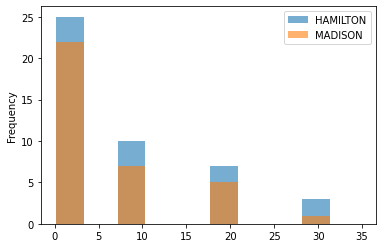

In [13]:
df_known.groupby('AUTHOR')['objection'].plot.hist(
    alpha=0.6, range=(0, 35), rwidth=0.9, legend=True);

In [14]:
import scipy.special

def negbinom_pmf(x, alpha, beta):
    """Negative binomial probability mass function."""
    # In practice this calculation should be performed on the log
    # scale to reduce the risk of numeric underflow.
    return (
        scipy.special.binom(x + alpha - 1, alpha - 1)
        * (beta / (beta + 1)) ** alpha
        * (1 / (beta + 1)) ** x
    )

print('Pr(X = 6):', negbinom_pmf(6, alpha=5, beta=1))
print('Pr(X = 14):', negbinom_pmf(14, alpha=5, beta=1))

Pr(X = 6): 0.1025390625
Pr(X = 14): 0.00583648681640625


count    51.000000
mean      7.019608
std       4.925404
min       1.000000
25%       5.000000
50%       6.000000
75%       9.000000
max      34.000000
Name: by, dtype: float64

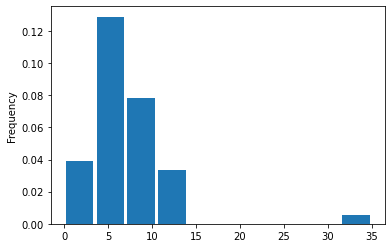

In [18]:
df_known[df_known['AUTHOR'] == 'HAMILTON']['by'].plot.hist(
    range=(0, 35), density=True, rwidth=0.9);
df_known[df_known['AUTHOR'] == 'HAMILTON']['by'].describe()

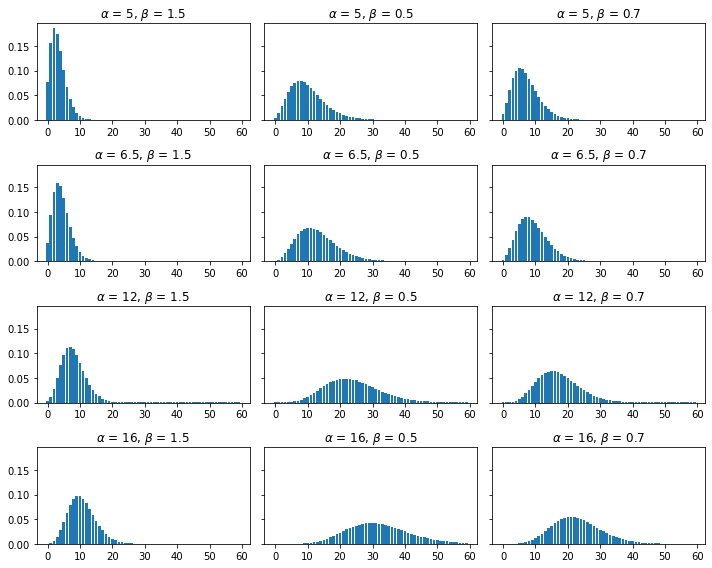

In [17]:
import itertools
import matplotlib.pyplot as plt

x = np.arange(60)
alphas, betas = [5, 6.5, 12, 16], [1.5, 0.5, 0.7]
params = list(itertools.product(alphas, betas))
pmfs = [negbinom_pmf(x, alpha, beta) for alpha, beta in params]

fig, axes = plt.subplots(4, 3, sharey=True, figsize=(10, 8))
axes = axes.flatten()

for ax, pmf, (alpha, beta) in zip(axes, pmfs, params):
    ax.bar(x, pmf)
    ax.set_title(fr'$\alpha$ = {alpha}, $\beta$ = {beta}')
plt.tight_layout();

In [19]:
def negbinom(alpha, beta, size=None):
    """Sample from a negative binomial distribution.

    Uses `np.random.negative_binomial`, which makes use of a
    different parameterization than the one used in the text.
    """
    n = alpha
    p = beta / (beta + 1)
    return np.random.negative_binomial(n, p, size)

samples = negbinom(5, 0.7, 10000)
# put samples in a pandas Series in order to calculate summary statistics
pd.Series(samples).describe()

count    10000.00000
mean         7.07620
std          4.11972
min          0.00000
25%          4.00000
50%          6.00000
75%          9.00000
max         29.00000
dtype: float64

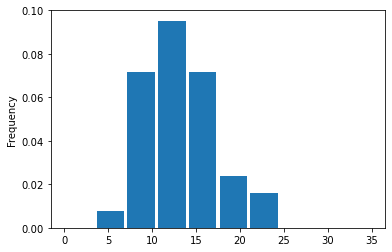

In [20]:
df_known[df_known['AUTHOR'] == 'MADISON']['by'].plot.hist(
    density=True, rwidth=0.9, range=(0, 35)  # same scale as with Hamilton
);

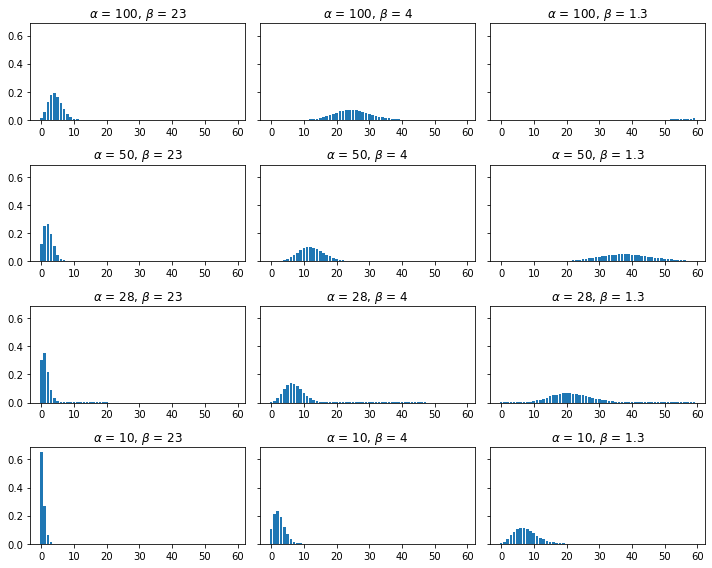

In [21]:
x = np.arange(60)
alphas, betas = [100, 50, 28, 10], [23, 4, 1.3]
params = list(itertools.product(alphas, betas))
pmfs = [negbinom_pmf(x, alpha, beta) for alpha, beta in params]

fig, axes = plt.subplots(4, 3, sharey=True, figsize=(10, 8))
axes = axes.flatten()

for ax, pmf, (alpha, beta) in zip(axes, pmfs, params):
    ax.bar(x, pmf)
    ax.set_title(fr'$\alpha$ = {alpha}, $\beta$ = {beta}')
plt.tight_layout()

In [22]:
authors = ('HAMILTON', 'MADISON')
alpha_hamilton, beta_hamilton = 5, 0.7
alpha_madison, beta_madison = 50, 4

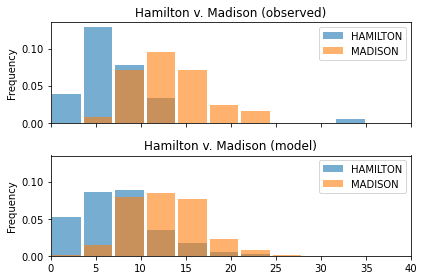

In [24]:
# observed
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
df_known.groupby('AUTHOR')['by'].plot.hist(
    ax=axes[0], density=True, range=(0, 35), rwidth=0.9, alpha=0.6,
    title='Hamilton v. Madison (observed)', legend=True)

# model
simulations = 10000
for author, (alpha, beta) in zip(authors, [(alpha_hamilton, beta_hamilton),
                                           (alpha_madison, beta_madison)]):
    pd.Series(negbinom(alpha, beta, size=simulations)).plot.hist(
        label=author, density=True, rwidth=0.9, alpha=0.6, range=(0, 35), ax=axes[1])
axes[1].set_xlim((0, 40))
axes[1].set_title('Hamilton v. Madison (model)')
axes[1].legend()
plt.tight_layout();

In [25]:
likelihood_hamilton = negbinom_pmf(14, alpha_hamilton, beta_hamilton)
print(likelihood_hamilton)

0.021512065936254765


In [26]:
likelihood_madison = negbinom_pmf(14, alpha_madison, beta_madison)
print(likelihood_madison)

0.08742647980678281
